### 0. 모듈 불러오기

In [ ]:
# 데이터 처리, 선형대수와 행렬 등 연산 모듈
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import re
import statsmodels.api as sm
import statsmodels.formula.api as sm
from statsmodels.formula.api import ols
import missingno as msno
from typing import *
import pandas_datareader as web
import pandas_datareader.data as web
import pandas_datareader as pdr

# 통계적 가설검정 모듈
from scipy.stats import *
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson

# 코랩에 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 데이터 시각화 모듈
import seaborn as sns
import matplotlib.pyplot as plt

# 증권 데이터 웹스크래핑 모듈
# !pip install --upgrade pandas
# !pip install --upgrade pandas-datareader
# !pip install lxml
!pip install pykrx
!pip install finance-datareader
!pip install yfinance
!pip install pybind11
  # 의존성 모듈로 함께 설치할 것(https://riskfolio-lib.readthedocs.io/en/latest/install.html)
!pip install riskfolio-lib

import requests
from bs4 import BeautifulSoup
from pykrx import stock
import pandas_datareader.famafrench as ff
import FinanceDataReader as fdr
import pandas_datareader as web
from pandas_datareader.famafrench import get_available_datasets
import yfinance as yf
yf.pdr_override()
import riskfolio as rp

In [2]:
# 한글 폰트 사용을 위해서 세팅

from matplotlib import font_manager, rc
font_path = r"/content/drive/MyDrive/FindAlpha_RiskyAsset1/archive/korean.ttf"
  # 오류가 발생한다면, 경로를 "/content/drive/FindAlpha_RiskyAsset1/archive/korean.ttf"로 설정
  # 혹은 로컬 폰트 경로인 "C:\\WINDOWS\FONTS\malgun.ttf"로 설정
font = font_manager.FontProperties(fname = font_path).get_name()
rc("font", family = font)

### 1. 자산배분을 최적화하는 요인모델, Fama-French Mutiple factor model
(자본자산가격결정모형 CAPM과의 차이를 중심으로 이해)
* 팩터에 기반한 전략적 자산배분(SAA)은 (수익률 등에 영향을 미치는) 자산군의 특성을 설명하는데 유용한 팩터를 선택한 후, 이들 팩터의 최적 배분 비중을 찾는 것이다. 
* 원칙적으로 베타(회귀계수)는 **최소 60종목 이상 일간 또는 주간이 아닌 월간 수익률 데이터**를 활용하여 산출하여야 한다.

In [ ]:
class FamaFrenchModel():
  
  def __init__(self, html: str, from_date = None, to_date = None, 
               data_name = None, multiFactorModeling_portfolio_data = None):
    self.html = html
    self.from_date = from_date
    self.to_date = to_date
      # "http://kind.krx.co.kr/corpgeneral/corpList.do?method=download"
    self.data_name = data_name
    self.multiFactorModeling_portfolio_data = multiFactorModeling_portfolio_data
    

  def ImportNameList(self, filtering_word1: str, filtering_word2: str):

  # 5요인 (R_market - R_free, HML, SMB, RMW, CMA) 데이터 셋 이름을 리스트에 담기
    datasets = ff.get_available_datasets( )
    data_name = [data for data in datasets if filtering_word1 in data and filtering_word2 in data]
    print(data_name)
    self.data_name = data_name
      # filtering_word1, 2(키워드)를 입력하여 프렌치 교수의 데이터 셋 명을 담은 리스트를 생성함
      # [input] {30, Industry} 
      # [output] ['30_Industry_Portfolios', '30_Industry_Portfolios_Wout_Div', '30_Industry_Portfolios_daily']
    

  def getStockCode(self, stock_list: List):

  # 주식종목코드 데이터프레임 stock_code 생성
    stock_code = pd.read_html(self.html, header = 0)[0]
    stock_code = stock_code[["종목코드", "회사명"]]
    stock_code["종목코드"] = stock_code["종목코드"].apply(
        lambda x: "0"*(6 - len(str(x))) + str(x))
      # 주식종목코드는 int 타입(연속형)으로 6자리에 맞추기 위한 0 추가하는 익명함수
    
    for stocks in stock_list:
      globals()["index_{}".format(stocks)] = stock_code[stock_code["회사명"] == stocks].index[0]
        # 회사명이 self.stock인 주식종목코드가 있는 행을 index_stock에 저장함

      globals()["code_{}".format(stocks)] = stock_code.iloc[globals()["index_{}".format(stocks)], 0]
        # 입력받은 self.stock의 주식종목코드를 code_stock에 저장함
      print(stocks, globals()["code_{}".format(stocks)])

    self.stock_list = stock_list


  def ImportDataFrame(self, n: int, ticker_name: str, from_date: str, to_date: str):
  
  # 월별 5요인 데이터 불러오기 (Feature Variable, X vector)

    # self.from_date = datetime.strptime(start, "%Y, %m, %d")
    # self.to_date = datetime.strptime(end, "%Y, %m, %d")
      # [ValueError] time data '2021,01,01' does not match format '%Y, %m, %d'

    self.from_date = from_date
    self.to_date = to_date

    factor_data = web.DataReader(self.data_name[n],
                                 "famafrench",
                                 start = self.from_date,
                                 end = self.to_date)
    print(factor_data["DESCR"])
      # portfolio_name 리스트에서 n번째 원소를 인덱싱하여 from_date부터 to_date까지의 포트폴리오 데이터 셋을 딕셔너리 타입으로 내려받음
    factor_data[0].index = factor_data[0].index.strftime("%Y-%m")
      # 인덱스의 종류를 YYYY-MM으로 날짜 형식 변환함
    factor_data = factor_data[0]
      # portfolio_data의 월별 5요인 데이터를 self.portfolio_data로 캡슐화함
      # 팩터를 구성하기 위해 한 국가의 주식을 2개의 시가총액과 3개의 B/M, 영업이익률(OP) 및 투자(INV) 그룹으로 분류

  # [Error] 자산포트폴리오 또는 개별증권의 월간 수익률 (Target Variable y)

    # for ticker in self.stock_list:
    stocks_data = stock.get_etf_ohlcv_by_date(fromdate = self.from_date, todate = self.to_date, ticker = ticker_name, freq = "m")
    stocks_data.index = stocks_data.index.strftime("%Y-%m")
    factor_data["expected_return"] = stocks_data["종가"].pct_change().fillna(0)
    # weight = np.ones(shape=(len(stocks_data.columns),)) / len(stocks_data.columns)

    # close = web.get_data_yahoo(ticker, start = self.from_date, end = self.to_date, interval = "m")["Adj Close"]
    # close.index = close.index.strtime("%Y-%m")
    # return_data = np.log(close).pct_change()[ 1: ]
      # yf.actions() : 배당, 분할 -> 수정주가 데이터로 해결할 수 있는 문제 (액면분할, 배당금, 권리행사 등의 영향을 반영)
      # yf.cashflow() / earnings() / balance_sheet()

    # multiFactorModeling_portfolio_data = pd.concat([return_data, factor_data], axis = 1, ignore_index = True)
        
    multiFactorModeling_portfolio_data = factor_data.copy()
    multiFactorModeling_portfolio_data.rename(columns = {"Mkt-RF":"market_excess_return"}, inplace = True)
    multiFactorModeling_portfolio_data["portfolio_excess_return"] = multiFactorModeling_portfolio_data["expected_return"] - multiFactorModeling_portfolio_data["RF"]
    self.multiFactorModeling_portfolio_data = multiFactorModeling_portfolio_data
    return self.multiFactorModeling_portfolio_data


  def preconditional_test(self):

  # 전제조건 1: 정규성 검정(Anderson-Darling Test, Jarque-bera Test) ShapiroWilk Test, KS Test에 비해 덜 엄격한 검정
    for column in self.multiFactorModeling_portfolio_data.select_dtypes(include = ["int64", "float64"]).columns.tolist():
      anderson_result = anderson(self.multiFactorModeling_portfolio_data[column], dist = "norm")
      if anderson_result[0] > anderson_result[1][2]:
        # [0] 검정통계량(statistic)
        # [1] 임계값(유의수준 a, 5% 이상이 되는 자리값, critical_values) 
        # [2] 임계값의 유의확률 p-value
        # [1][2] 정규성 검정통계량이 유의수준 5% 검정통계량보다 클 경우, 정규분포를 따름
        print(f"{column}변수는 정규분포를 따르지 않는다")
      else: 
        print(f"{column}변수는 정규분포를 따른다")
    print("\n")

  # 전제조건 1: 정규성 검정(Jarque-bera Test) 왜도와 첨도를 이용한 검정
    for column in self.multiFactorModeling_portfolio_data.select_dtypes(include = ["int64", "float64"]).columns.tolist():
      jb_result = jarque_bera(self.multiFactorModeling_portfolio_data[column])
      if jb_result[1] < 0.05:
        print(f"{column}변수는 정규분포를 따르지 않는다")
      else: 
        print(f"{column}변수는 정규분포를 따른다")
    print("\n")


  # 전제 조건 2: 등분산성 검정(정규성이 성립하지 않을 경우 Levene Test)
    for column_1 in self.multiFactorModeling_portfolio_data.select_dtypes(include = ["int64", "float64"]).columns.tolist():
      for column_2 in self.multiFactorModeling_portfolio_data.select_dtypes(include = ["int64", "float64"]).columns.tolist():
        if column_1 != column_2:
          levene_result = levene(self.multiFactorModeling_portfolio_data[column_1], self.multiFactorModeling_portfolio_data[column_2])
          
          if levene_result[1] < 0.05:
            print(f"{column_1}변수와 {column_2}변수의 이분산성은 통계적으로 유의하다")
          else:
            print(f"{column_1}변수와 {column_2}변수은 등분산성 조건이 성립한다")
        
        else: # column_1 == column_2:
          pass

  # 전제 조건 3 : 다중공선성(multicollinearity)
  # 독립변수 간 상관관계가 높으면 2가지 문제가 발생함
  # (1) 유의해야 할 회귀계수 추정치가 유의하지 않게 추정됨
  # (2) 회귀계수 추정치 부호가 반대로 유의하게 추정됨
    correlation = self.multiFactorModeling_portfolio_data.drop("portfolio_excess_return", axis = 1).corr()  
      # 데이터프레임의 상관계수 행렬
    mask = np.zeros_like(correlation, dtype = np.bool)
      # 상관분석 히트맵 삼각형 마스크(위 쪽 삼각형에 True, 아래 삼각형에 False)
    mask[np.triu_indices_from( mask )] = True
    sns.heatmap(data = correlation, 
                cmap = "GnBu_r", 
                  # colormap 팔레트
                annot = True, 
                  # 실제값 표시
                fmt = "0.01f",
                  # 소수점 둘째 자리까지 표시
                mask = mask, 
                  # 표시하지 않을 위쪽 삼각형 마스크 부분 지정
                linewidths = 0.5, 
                  # 경계면 실선으로 구분
                vmin = -1,
                vmax = 1
                  # colorbar의 범위 -1 ~ 1로 지정
                )
      # 상관계수 히트맵
    plt.show()

  
  def linearRegression(self, linearRegFormula: object):
  
  # (시계열) 다중선형회귀분석 모형 추정
    FF_5factor_linearRegModel = sm.ols(
        formula = linearRegFormula, data = self.multiFactorModeling_portfolio_data
    ).fit()
    print(FF_5factor_linearRegModel.summary())
    print(FF_5factor_linearRegModel.params.apply(
        lambda x: 
        (x - FF_5factor_linearRegModel.params.mean()) / FF_5factor_linearRegModel.params.std()))

  # 전제 조건 4 : 잔차의 정규성 및 독립성 검정
  # 회귀계수(모형식의 파라미터)의 편의가 발생하고 예측의 신뢰성이 낮아지는 오차의 자기상관관계가 없는지 Durbin Watson 검정
    residual_jb_result = jarque_bera(FF_5factor_linearRegModel.resid)
    if residual_jb_result[1] < 0.05:
      print("회귀식의 잔차는 정규분포를 따르지 않는다")
    else: 
      print("회귀식의 잔차는 정규분포를 따른다")
    print("\n")
    sns.distplot(x = FF_5factor_linearRegModel.resid)
    plt.title("Residuals Histogram")

    print(f"회귀식 잔차의 DW-통계량은 {round(durbin_watson(FF_5factor_linearRegModel.resid), 4)}이다")
      # 일반적으로 1.5 ~ 2.5사이 값이면 자기상관관계가 없어 독립이라고 판단함
      # 0에 가까울수록 잔차들은 양의 자기상관을 가짐
      # 2에 가까울수록 자기상관이 없어짐
      # 2보다 크고 4에 가까워질수록 잔차들은 음의 자기상관을 가짐

"""
  # 결정계수 : 선행조건(train : test split and predict test with train model)
  # 분산팽창인자 1 / 1 - R^2 (VIF: variance inflation factor), 10 이상이면 다중공선성 有

    y_test, y_pred = 0, 0
    SST = sum(y_test - y_test.mean())**2
      # 편차의 제곱(Total Sum of Squqres) = 총변동
    SSR = sum(y_pred - y_test.mean())**2
      # 편차와 잔차의 차이 제곱(Regression sum of squares) = 추정회귀식으로 설명가능한 변동
    SSE = sum(FF_5factor_linearRegModel.resid)**2
      # 잔차의 제곱(Error Sum of Squares) = 회귀식으로 설명할 수 없는 변동
    R_squared = (1 - SSE/SST)
    k = len(self.multiFactorModeling_portfolio_data) - 1
    n = FF_5factor_linearRegModel.nobs
    Adjusted_R_squared = 1 - (SSE/(n-k-1)) / (SST/(n-1))
"""

```
FF = FamaFrenchModel(html = "http://kind.krx.co.kr/corpgeneral/corpList.do?method=download")
FF.ImportNameList(filtering_word1 = "5", filtering_word2 = "Factor")
```
```
DF = FF.ImportDataFrame(n = -1, from_date = "20210101", to_date = "20230101", ticker_name = "102110") 
  # [102110] TIGER 200 ETF
DF
FF.preconditional_test()
  # 선형회귀식 추정 전 모형 전제요건에 대한 가설검정 및 상관분석
FF.linearRegression(linearRegFormula = "portfolio_excess_return ~ market_excess_return + SMB + HML + RMW + CMA")
  # Fama French 5 Factors Model
FF.linearRegression(linearRegFormula = "portfolio_excess_return ~ market_excess_return")
  # Capital Asset Price Model
```

---

### 2. 다요인모형에 대한 또 한 번의 문샷
다중선형회귀계수 즉, 요인민감도를 통해 증권 투자로 특정위험을 감수하는 것에 대한 보상을 (위험/보상관계) 계량화한다. 단, 이때 리스크 팩터는 (1) 팩터의 견고함(robustness)과 (2) 팩터의 단순함을 갖추어야 한다. 결국 투자자는 새로운 팩터를 설계하고 테스트하면서 유효성을 검증하여야 할 것이다.

팩터의 비중을 조절하면 횡적 리스크 모델(cross-sectional risk models), 팩터포트폴리오와 무위험자산의 비중을 동적으로 조절하면 종적 리스크 모델(time-series risk models)라고 한다.

출처
* [김동영 외 1인, 삼성증권, Fama-French 3 Factor Model - 전후편, 2018](https://www.smallake.kr/wp-content/uploads/2018/08/Back_to_Basic_Fama-French_3_%ed%8c%a9%ed%84%b0_%eb%aa%a8%eb%8d%b8_-_%ed%9b%84%ed%8e%b820180703171930.pdf)
* [FnGuide, Factor 포트폴리오 구성 방법](https://www.fnguide.com/download/Factor_Model_Methodology.pdf)
* [Kenneth R. French, U.S. Research Returns Data](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)
* [Steven Downey, How to Build a Multi-Factor Equity Portfolio in Python, Medium article](https://medium.com/swlh/how-to-build-a-multi-factor-equity-portfolio-in-python-4560fab3df7b)
* [파이썬으로 배우는 포트폴리오](https://thebook.io/080227/ch06/05/02-02/)

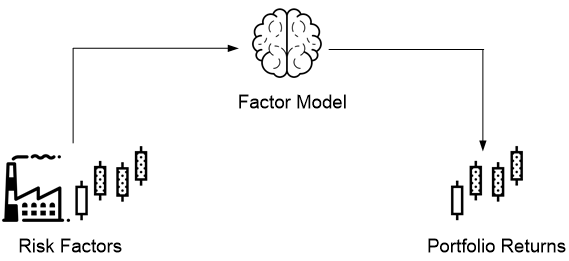

예시 : 미래에셋자산운용의 미래에셋AI스마트베타EMP증권자투자신탁(주식-재간접형)

장기적 초과수익이 기대되는 다양한 팩터(Factor) 비중을 인공지능 알고리즘 모델을 활용해서 투자

예시 : 삼성 Factor 모델(매크로 다이나믹 모델) 기반의 포트폴리오 전략

19/4/15 “팩터 모델의 구조와 해설: Factor Models for Asset Returns”

21/1/11 “주식 스타일 Fact Book”

21/7/16 “월간 팩터 추천 종목: 2021년 7월 ~ 8월”

#### **Fama-French 3-팩터 모델**
투자자산 또는 포트폴리오의 초과수익을 설명하는 2가지 팩터를 추가하여 확장한 CAPM(자본자산가격결정모형)
* $ E(r_i) - r_f = a + B_{mkt}⋅MKT + B_{smb}⋅SMB + B_{hml}⋅HML $
* 시장 팩터(MKT, Market Factor) 주식시장 내 모든 주식들을 포함한 포트폴리오의 시총가중
수익률

  (무위험수익률의 예 : 매월 월초 기준의 CD 91일물 금리)

* 규모 팩터(SMB, Small Minus Big) 시가총액이 큰 주식 대비 시가총액(주식가격 * 발행주식 수)이 작은 주식의 초과수익률을 측정한다.
* 가치 팩터(HML, High Minus Low) 성장주식 대비 초과가치 주식의 초과수익률을 측정한다. 가치주식은 높은 시장가 대비 장부가(Book to Market) 비율을 가지고 성장주식은 B/M비율이 낮다.
* 회귀분석에서 종속변수로 활용되는 $ E(r_i) - r_f $는 다음과 같이 측정한다. 시가총액과 B/M비율을 활용하여 5x5,  주식포트폴리오 25개 형태로 만든다. 이는 각 t년 6월 말 주식을 시가총액 기준으로 5개 그룹으로 나누며 PBR의 역수인 B/M비율 기준으로 5개 그룹으로 나눈다. 그 다음 이들의 교집합을 통해 5x5 포트폴리오를 만든다. 이후 포트폴리오별 시가총액 가중수익률을 측정한다. 

#### **Carhart 4-팩터 모델**
투자자산 또는 포트폴리오의 초과수익을 설명하는 2가지 팩터를 추가하여 확장한 CAPM(자본자산가격결정모형)
* $ E(r_i) - r_f = a + B_{mkt}⋅MKT + B_{smb}⋅SMB + B_{hml}⋅HML + B_{wml}⋅WML $
* 시장 팩터(MKT, Market Factor)
* 규모 팩터(SMB, Small Minus Big)
* 가치 팩터(HML, High Minus Low)
* 모멘텀 팩터(WML, Winners Minus Losers) 과거 12개월 동안의 loser 주식에 대한 winner 주식의 초과수익을 측정한다. 

#### **Fama-French 5-팩터 모델**
투자자산 또는 포트폴리오의 초과수익을 설명하는 2가지 팩터를 추가하여 확장한 CAPM(자본자산가격결정모형)
* $ E(r_i) - r_f = a + B_{mkt}⋅MKT + B_{smb}⋅SMB + B_{rmw}⋅RMW + B_{cma}⋅CMA $
* 시장 팩터(MKT, Market Factor)
* 규모 팩터(SMB, Small Minus Big)
* 가치 팩터(HML, High Minus Low)
* 수익성 팩터(RMW, Robust Minus Weak) 영업활동 현금흐름에 따른 영업이익 (이익인지 변화율인지 확인 필요)이 낮은 회사에 비해 높은 회사의 초과 수익률을 측정한다. 
* 투자 팩터(CMA, Conservative Minus Aggressive) 저투자정책 회사의 중급 이상 투자정책 회사 대비 초과 이익률을 측정한다.

* FnGuide에 따르면 이외에도 배당성, 거시경제민감도, 단기 return, 저변동성, 종목의견 등의 팩터(스타일 리스크 팩터와 업종 리스크 팩터)가 있다. 

### **CrawlingFinancialData()**

In [143]:
# 네이버 금융, FnGuide에서 상장주식회사의 연결재무제표 데이터를 크롤링하는 함수
# pykrx의 문제는 발행주식 수의 변화(액면분할)를 반영하지 못하면서 단순히 주가에서 EPS를 나눠주는 방법으로 PER 등을 계산

class CrawlingFinancialData():
  
  def __init__(self, html_stock_code: str, url_naver_finance: str, 
               operating_profit_margin = None, net_profit_margin = None, return_on_equity = None, debt_ratio = None, price_to_book_value_ratio = None, divendend_payout_ratio = None):

    self.html_stock_code = html_stock_code
    self.url_naver_finance = url_naver_finance

    self.operating_profit_margin = operating_profit_margin
    self.net_profit_margin = net_profit_margin
    self.return_on_equity = return_on_equity
    self.debt_ratio = debt_ratio
    self.price_to_book_value_ratio =  price_to_book_value_ratio
    self.divendend_payout_ratio = divendend_payout_ratio


# getStockCode() : 상장주식종목 코드번호를 html을 통해 데이터프레임 형태로 불러오는 함수
  def getStockCode(self) -> pd.DataFrame:
  
  # 1. 상장지수 회사명 및 종목코드 데이터를 불러오기
    KOSPI_code_list = pd.read_html(self.html_stock_code + "?method=download&marketType=stockMkt")[0]
    KOSDAQ_code_list = pd.read_html(self.html_stock_code + "?method=download&marketType=kosdaqMkt")[0]
    KOSPI_code_list = KOSPI_code_list[["회사명", "종목코드"]]
    KOSDAQ_code_list = KOSDAQ_code_list[["회사명", "종목코드"]]
      # 각 시장별 회사명, 종목코드만 추출
    KOSPI_code_list["종목코드"] = KOSPI_code_list["종목코드"].apply(lambda x: "0"*(6 - len(str(x))) + str(x))
    KOSDAQ_code_list["종목코드"] = KOSDAQ_code_list["종목코드"].apply(lambda x: "0"*(6 - len(str(x))) + str(x))
      # 주식종목코드는 int 타입(연속형)으로 6자리에 맞추기 위한 0 추가하는 익명함수(lambda)

  # 2. KOSPI, KOSDAQ 상장주식종목에서 리츠와 ETF를 제거
  # 문자열 정규표현식에서 "리츠"와 "스팩"을 필터링하여 해당 행 번호를 추출하여 데이터프레임에서 삭제
    KOSPI_code_list.drop(
        KOSPI_code_list[KOSPI_code_list["회사명"].str.contains(r"(스팩)") == True].index.tolist(), axis = 0, inplace = True)
    KOSPI_code_list.drop(
        KOSPI_code_list[KOSPI_code_list["회사명"].str.contains(r"(리츠)") == True].index.tolist(), axis = 0, inplace = True)
    KOSDAQ_code_list.drop(
        KOSDAQ_code_list[KOSDAQ_code_list["회사명"].str.contains(r"(스팩)") == True].index.tolist(), axis = 0, inplace = True)
    KOSDAQ_code_list.drop(
        KOSDAQ_code_list[KOSDAQ_code_list["회사명"].str.contains(r"(리츠)") == True].index.tolist(), axis = 0, inplace = True)
    return KOSPI_code_list, KOSDAQ_code_list


# corporationBalanceSheetConnect() : 네이버 금융에서 KOSPI 상장주식종목 재무데이터를 크롤링하여 딕셔너리 형태로 불러오는 함수
  def corporationBalanceSheetConnect(self, stock_code_list: pd.DataFrame):

  # 3. 상장기업의 영업이익률, 순이익률, ROE, 부채비율, PBR(시가총액 / 순자산), 배당성향 각 데이터프레임 생성
    operating_profit_margin = pd.DataFrame(index = range(0, 10), columns = stock_code_list["회사명"])
    net_profit_margin = pd.DataFrame(index = range(0, 10), columns = stock_code_list["회사명"])
    return_on_equity = pd.DataFrame(index = range(0, 10), columns = stock_code_list["회사명"])
    debt_ratio = pd.DataFrame(index = range(0, 10), columns = stock_code_list["회사명"])
    price_to_book_value_ratio = pd.DataFrame(index = range(0, 10), columns = stock_code_list["회사명"])
    divendend_payout_ratio = pd.DataFrame(index = range(0, 10), columns = stock_code_list["회사명"])
      # 배당성향 = 배당금 / 당기손익 * 100 (주주에 대한 이익사외분배율)

  # 4. 네이버 금융 웹페이지를 크롤링하여 팩터 생성을 위한 분기, 연도별 6개 재무데이터프레임을 저장하는 반복문 수행
    for index_stock_code in range(len(stock_code_list)):
      try:
        url_stock = "https://finance.naver.com/item/main.nhn?code={}".format(
            stock_code_list["종목코드"][ index_stock_code ])
          # KeyError: 36, 39
          # 매핑 (딕셔너리) 키가 기존 키 집합에서 발견되지 않을 때 발생
        response_stock = requests.get(url_stock, headers = {"User-agent" : "Mozilla/5.0"})
        html_stock = response_stock.text
        soup_object_stock = BeautifulSoup(html_stock, "lxml")
        html_finance = soup_object_stock.select("div.section.cop_analysis div.sub_section")[0]
          # CSS Selector
          # IndexError: list index out of range
        th_data_finance = [
            element.get_text().strip() 
            for element in html_finance.select("thead th")]
        date_annual = th_data_finance[3:7]
        date_quarter = th_data_finance[7:13]
        date_finance = date_annual + date_quarter
          # html 구조는 "table" > "tbody" > "tr" > "th" > "strong" tag
          # 재무제표 날짜 정보 element를 html 웹페이지의 soup 객체에서 thead 태그와 th 태그에서 추출

        index_finance = [
            element.get_text().strip()
            for element in html_finance.select("th.h_th2")
        ][3:]
          # 재무정보 지표 element를 th태그의 h_th2 클래스에서 추출

        td_data_finance = [
            element.get_text().strip() 
            for element in html_finance.select('td')
        ]
          # 재무제표 계정과목의 데이터 element를 td 태그에서 추출
        data_finance = np.array( td_data_finance )
        data_finance.resize( len(index_finance), 10 )
          # 재무제표 계정과목 데이터가 담긴 리스트를 넘파이 배열로 변환

        final_data_finance = pd.DataFrame(
            data = data_finance,
            index = index_finance,
            # columns = date_finance
        ).T
          # 최종 해당 종목코드의 상장기업의 재무 데이터프레임
          # ValueError: cannot reindex from a duplicate axis

        operating_profit_margin[ stock_code_list["회사명"][index_stock_code] ] = final_data_finance["영업이익률"]
        net_profit_margin[ stock_code_list["회사명"][index_stock_code] ] = final_data_finance["순이익률"]
        return_on_equity[ stock_code_list["회사명"][index_stock_code] ] = final_data_finance["ROE(지배주주)"]
        debt_ratio[ stock_code_list["회사명"][index_stock_code] ] = final_data_finance["부채비율"]
        price_to_book_value_ratio[ stock_code_list["회사명"][index_stock_code] ] = final_data_finance["PBR(배)"]
        divendend_payout_ratio[ stock_code_list["회사명"][index_stock_code] ] = final_data_finance["배당성향(%)"]
      
      except (KeyError, IndexError) as error:
        # print(error)
        pass
        # 딕셔너리 key 에러나 리스트의 index 에러가 있을 경우
        # [continue] 바로 다음 순번의 for loop를 수행
        # [pass] 실행할 코드가 없는 것으로 다음 행동을 수행
        # [break] 반복문 종료

    operating_profit_margin.index = date_finance
    net_profit_margin.index = date_finance
    return_on_equity.index = date_finance
    debt_ratio.index = date_finance
    price_to_book_value_ratio.index = date_finance
    divendend_payout_ratio.index = date_finance
      # 향후 index_to_datetime() 사용자 정의함수를 class 내부에서 멤버함수 간 공유하는 형태 또는
      # self를 인자로 받지 않는 전역공간에 index_to_datetime()을 통해 기능이 반복되는 내용 자동화
    
    self.operating_profit_margin = operating_profit_margin
    self.net_profit_margin = net_profit_margin
    self.return_on_equity = return_on_equity
    self.debt_ratio = debt_ratio
    self.price_to_book_value_ratio = price_to_book_value_ratio
    self.divendend_payout_ratio = divendend_payout_ratio


  # 5. 각 시장별 재무데이터프레임을 datetime인덱스를 반영하여 csv 파일로 저장 
  # 매번 크롤링해서 데이터를 불러오려면 13 ~ 15분 소요되므로 편의성을 위해 최초 1회만 실행
  def KOSPI_dataframe_to_csvfile(self, googledrive_path: str):
    self.operating_profit_margin.to_csv("{}/KOSPI_영업이익률.csv".format(googledrive_path), index = True)
    self.net_profit_margin.to_csv("{}/KOSPI_당기손익률.csv".format(googledrive_path), index = True)
    self.return_on_equity.to_csv("{}/KOSPI_자기자본이익률.csv".format(googledrive_path), index = True)
    self.debt_ratio.to_csv("{}/KOSPI_부채비율.csv".format(googledrive_path), index = True)
    self.price_to_book_value_ratio.to_csv("{}/KOSPI_주당순자산가치비율_PBR.csv".format(googledrive_path), index = True)
    self.divendend_payout_ratio.to_csv("{}/KOSPI_배당성향.csv".format(googledrive_path), index = True)
  

  def KOSDAQ_dataframe_to_csvfile(self, googledrive_path: str):
    self.operating_profit_margin.to_csv("{}/KOSDAQ_영업이익률.csv".format(googledrive_path), index = True)
    self.net_profit_margin.to_csv("{}/KOSDAQ_당기손익률.csv".format(googledrive_path), index = True)
    self.return_on_equity.to_csv("{}/KOSDAQ_자기자본이익률.csv".format(googledrive_path), index = True)
    self.debt_ratio.to_csv("{}/KOSDAQ_부채비율.csv".format(googledrive_path), index = True)
    self.price_to_book_value_ratio.to_csv("{}/KOSDAQ_주당순자산가치비율_PBR.csv".format(googledrive_path), index = True)
    self.divendend_payout_ratio.to_csv("{}/KOSDAQ_배당성향.csv".format(googledrive_path), index = True)

In [144]:
ImportData = CrawlingFinancialData(
    html_stock_code = "https://kind.krx.co.kr/corpgeneral/corpList.do",
    url_naver_finance = "https://finance.naver.com/sise/sise_market_sum.nhn"
)

In [145]:
KOSPI_code_list, KOSDAQ_code_list = ImportData.getStockCode()

<ipython-input-143-2d0d0786a875>:36: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  KOSPI_code_list[KOSPI_code_list["회사명"].str.contains(r"(스팩)") == True].index.tolist(), axis = 0, inplace = True)
<ipython-input-143-2d0d0786a875>:38: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  KOSPI_code_list[KOSPI_code_list["회사명"].str.contains(r"(리츠)") == True].index.tolist(), axis = 0, inplace = True)
<ipython-input-143-2d0d0786a875>:40: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  KOSDAQ_code_list[KOSDAQ_code_list["회사명"].str.contains(r"(스팩)") == True].index.tolist(), axis = 0, inplace = True)
<ipython-input-143-2d0d0786a875>:42: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  KOSDAQ_code_list[KOSDAQ_code_list["회사명"].str.contains(r"(리츠)") == True].index.tolist(), axis = 0, inplace = True)


In [146]:
print(KOSPI_code_list, "\n", KOSDAQ_code_list)

            회사명    종목코드
0         DRB동일  004840
1           DSR  155660
2            GS  078930
3     HDC현대산업개발  294870
4         KG케미칼  001390
..          ...     ...
820        현대위아  011210
821     현대코퍼레이션  011760
822  현대코퍼레이션홀딩스  227840
823          화신  010690
824        흥아해운  003280

[801 rows x 2 columns] 
              회사명    종목코드
0     CJ 바이오사이언스  311690
1         DH오토웨어  025440
2           ES큐브  050120
4         KB오토시스  024120
5          KH 전자  111870
...          ...     ...
1620          한탑  002680
1621       해성옵틱스  076610
1622     헥토이노베이션  214180
1623      홈센타홀딩스  060560
1624          힘스  238490

[1554 rows x 2 columns]


In [129]:
ImportData.corporationBalanceSheetConnect(stock_code_list = KOSDAQ_code_list)
  # [stock_code_list] KOSPI_code_list, KOSDAQ_code_list

In [ ]:
ImportData.KOSDAQ_dataframe_to_csvfile(googledrive_path = "/content/drive/MyDrive/FindAlpha_RiskyAsset1/data")
  # 에러날 경우 "content/drive/FindAlpha_RiskyAsset1"로 재실행

---

#### Trial & Error 1

```
url_stock = "https://finance.naver.com/item/main.naver?code=" + KOSPI_code_list["종목코드"][0]
  # html 문서의 tag 내 <href> 속성값을 가져와 url_bs_data에 저장
  # [NAVER] view-source:https://finance.naver.com/ + item/main.naver?code=035420
  # 링크를 읽어와서 딕셔너리 형태로 참조함
request_get_stock = requests.get(url_stock, headers = {"User-agent" : "Mozilla/5.0"})
soup_object_stock = BeautifulSoup(request_get_stock.text, "lxml")

parameter_list: List = ["영업이익률", "순이익률", "ROE(지배주주)", "PBR(배)", "배당성향(%)"]
    # 배당성향 = 배당금 / 당기손익 * 100 (주주에 대한 이익사외분배율)
# 새 섹션
for parameter_text in parameter_list:
  if soup_object_stock.find("strong", text = parameter_text) is not None:
  parameter = " ".join(soup_object_stock.find("strong", text = parameter_text).parent["class"])  
      # html 구조는 "table" > "tbody" > "tr" > "th" > "strong" tag
      # 파라미터에 parent 노드로 이동하여 상위 <th> 태그로 이동

# 3. 클래스명이 h_th2 th_cop_anal8인 상위 element로 이동 후 하위 td element값을 가져와 리스트에 저장
  # <th scope="row" class="h_th2 th_cop_anal8"><strong>매출액</strong></th>
    # <td class=""> 53,041

  tbody_stock = soup_object_stock.find("table", attrs = {"class" : "tb_type1 tb_num tb_type1_ifrs"}).find("tbody")
  title_stock = soup_object_stock.find("th", attrs = {"class" : parameter})
    # 파라미터에 매핑되는 row 검색하여 상위 <td> 태그로 이동 후 해당 row의 모든 td 컬럼 가져와 parameter_data에 저장
    # attrs = {"class" : "~"}는 class의 속성의 값(attributes)이 "~"를 가지는 <th> 태그의 element 가져오기

  parameter_data = soup_object_stock.find("th", attrs = {"class" : parameter}).parent.find_all("td")
  parameter_value = [data.get_text().strip() for data in parameter_data]
    # parameter_data 내 각 컬럼을 data변수로 지정 후 좌우공백제거를 반복하는 for문 리스트 컴프리핸션 수행

  thead_stock = soup_object_stock.find("table", attrs = {"class" : "tb_type1 tb_num tb_type1_ifrs"})

  else: pass

# 4. 각 재무 데이터의 시점(연간, 분기 연월 정보) 가져오기
  # <table summary="기업실적분석에 관한표이며 주요재무정보를 최근 연간 실적, 분기 실적에 따라 정보를 제공합니다." class="tb_type1 tb_num tb_type1_ifrs">
		# <caption>기업실적분석 테이블</caption>

  if thead_stock is not None:
    datetime_stock = thead_stock.find("thead").find_all("th", attrs = {"scope" : "col", "class" : ""})
  else: # thead_stock is None
    continue
```

#### Trial & Error 2

```
re_encparam = re.compile("encparam: '(.*)'", re.IGNORECASE)
re_id = re.compile("id: '([a-zA-Z0-9]*)' ?", re.IGNORECASE)
url_stock = "http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd={}".format(KOSPI_code_list["종목코드"][0])
html_stock = requests.get(url_stock).text
encparam = re_encparam.search(html_stock).group(1)
encid = re_id.search(html_stock).group(1)

url_stock_enc = "http://companyinfo.stock.naver.com/v1/company/ajax/cF1001.aspx?cmp_cd={}&fin_typ=0&freq_typ=A&encparam={}&id={}".format(KOSPI_code_list["종목코드"][0], encparam, encid) 
html_stock_enc = requests.get(url_stock_enc, headers = {"Referer": "HACK"}).text

dfs = pd.read_html(html_stock_enc)
df_quarter = dfs[1]['분기분기컨센서스보기']
df_year = dfs[1]["연간연간컨센서스보기"]
  # pandas read_html()을 통해 html 태그 중 table 태그를 데이터프레임으로 변환

df = pd.concat([df_quarter, df_year], axis = 1)
df.drop(["2022/12(E)  (IFRS연결)", "2022/12(E)  (IFRS연결)"], axis = 1, inplace = True)
df.index = dfs[1]['주요재무정보'].values.flatten()
  # 다시 리스트로 반환
df = df.T
  # 행렬 전환
```

#### Trial & Error 3
OpenDart의 개인용 API Key의 일일호출제한은 1만건

---

### **getFactorData()**

1. 주가수익률과 재무제표 지표 간 시점 통일(주가수익률은 월별, 시가총액은 연간, 기타 재무제표 지표는 분기 혹은 연간)

2. 가치 / 규모 / 모멘텀 / 수익성 / 안정성 / 투자 팩터 상위 10%, 하위 10% 
주식종목군을 각 저장하는 데이터프레임 생성 (10%는 예시일뿐)
  
  content/drive/FindAlpha_RiskyAsset1/data/에 있는 csv 파일 로드

3. 각 종목군의 월별 초과수익률의 기하평균의 차를 벡터(numpy.array 또는 pd.Series 형태)로 저장

4. 시장 팩터 별도로 생성하며 월별 무위험수익률 데이터를 크롤링하여야 함

  네이버 금융 CD(양도성예금증서) 91물 또는 국고채 금리

5. 민감도(베타, 회귀계수)를 측정할 투자자산 포트폴리오 구성

In [142]:
pd.set_option("display.max_columns", None)
코스피_영업이익률 = pd.read_csv("/content/drive/MyDrive/FindAlpha_RiskyAsset1/data/KOSPI_영업이익률.csv", index_col = 0)
코스닥_영업이익률 = pd.read_csv("/content/drive/MyDrive/FindAlpha_RiskyAsset1/data/KOSDAQ_영업이익률.csv", index_col = 0)
코스피_영업이익률

,DRB동일,DSR,GS,HDC현대산업개발,KG케미칼,KPX케미칼,KSS해운,KTis,LG이노텍,LG헬로비전,LX하우시스,LX홀딩스,MH에탄올,OCI,PI첨단소재,POSCO홀딩스,SK스퀘어,SK이노베이션,STX,WISCOM,갤럭시아에스엠,경농,경동인베스트,국도화학,국보,극동유화,노루페인트,녹십자홀딩스,대덕전자,대성산업,동원산업,동화약품,두산퓨얼셀,락앤락,롯데정보통신,롯데지주,명문제약,모나리자,보령,부국증권,비케이탑스,삼성엔지니어링,삼성출판사,삼양식품,삼양홀딩스,삼익THK,삼호개발,선진,세방전지,신대양제지,신도리코,신세계인터내셔날,신풍,신한지주,에이블씨엔씨,영풍제지,영화금속,영흥,오뚜기,오리온,우진,윌비스,유나이티드,인지컨트롤스,인터지스,일성건설,일진다이아,자화전자,제일약품,제일파마홀딩스,조비,종근당홀딩스,진에어,케이씨티시,코오롱글로벌,콤텍시스템,키다리스튜디오,태양금속공업,토니모리,한국ANKOR유전,한미사이언스,한샘,한솔로지스틱스,한솔테크닉스,한일철강,한일홀딩스,한창제지,한화생명,한화솔루션,핸즈코퍼레이션,현대건설,현대로템,현대비앤지스틸,현대자동차,현대차증권,호전실업,AK홀딩스,CJ CGV,CJ씨푸드,CJ제일제당,CS홀딩스,DN오토모티브,DSR제강,F&F 홀딩스,GS리테일,HDC,JW홀딩스,KB금융,KEC,KR모터스,LS전선아시아,SKC,SK디앤디,SNT모티브,강원랜드,경동나비엔,교보증권,금강공업,금호건설,금호전기,녹십자,다올투자증권,대구백화점,대성에너지,대우건설,대원강업,대원제약,대한방직,대한해운,더존비즈온,덕양산업,동아에스티,동아지질,동양생명,동원F&B,동원금속,디아이,롯데정밀화학,무학,보락,빙그레,사조대림,삼부토건,삼화페인트공업,서원,세방,세아홀딩스,세우글로벌,세원정공,세이브존I&C,세하,솔루스첨단소재,수산중공업,신송홀딩스,신일전자,쎌마테라퓨틱스,아이마켓코리아,아이에이치큐,에스엠벡셀,에이프로젠,에이프로젠바이오로직스,엔씨소프트,영보화학,유니드비티플러스,유니온머티리얼,이수화학,이스타코,인디에프,인천도시가스,일동홀딩스,조흥,카카오뱅크,코리아써키트,코아스,코오롱,코오롱플라스틱,큐로,크래프톤,태경비케이,태광산업,태영건설,티비에이치글로벌,포스코케미칼,하나투어,하이트진로,한국금융지주,한국전자홀딩스,한국조선해양,한국종합기술,한국타이어앤테크놀로지,한국프랜지공업,한미약품,한온시스템,한올바이오파마,한화,호텔신라,화승인더스트리,화천기공,환인제약,효성,효성화학,흥국화재,BGF리테일,GS건설,LG전자,SBS,SG글로벌,SK가스,SK디스커버리,SK렌터카,STX중공업,YG PLUS,국동,국제약품,금양,금호타이어,남선알미늄,다스코,다이나믹디자인,대한유화,더블유게임즈,동방아그로,동서,동성케미컬,동양,동양철관,동원시스템즈,동일제강,디와이,마니커,맥쿼리인프라,메타랩스,모토닉,미래에셋생명,미원화학,바이오노트,백산,범양건영,삼성바이오로직스,삼성증권,삼성카드,삼영무역,삼일제약,삼정펄프,상상인증권,샘표식품,서연이화,성보화학,성신양회,세아베스틸지주,송원산업,신성이엔지,신세계푸드,쌍용씨앤이,씨아이테크,아모레퍼시픽그룹,아이에스동서,아주스틸,애경산업,애경케미칼,엔에이치엔,예스코홀딩스,우성,웅진,유니켐,유화증권,이구산업,이노션,이마트,일성신약,제이에스코퍼레이션,제일기획,종근당바이오,지역난방공사,지투알,진도,진양화학,코스모신소재,태평양물산,텔코웨어,티와이홀딩스,팜스코,하이스틸,하이트론씨스템즈,한국수출포장공업,한국앤컴퍼니,한국자산신탁,한국전력공사,한국주강,한솔홀딩스,한신기계공업,한일시멘트,한화에어로스페이스,해태제과식품,현대그린푸드,현대글로비스,현대중공업,화승알앤에이,효성 ITX,휴니드테크놀러지스,AJ네트웍스,BNK금융지주,CJ대한통운,DB손해보험,DL,E1,F&F,HL D&I,HMM,KPX홀딩스,LG생활건강,LG화학,LIG넥스원,NH투자증권,NICE,NI스틸,SH에너지화학,SK네트웍스,SK증권,SK텔레콤,경인양행,경인전자,교촌에프앤비,기신정기,까뮤이앤씨,넥센타이어,농심,대덕,대동전자,대림비앤코,대양금속,대웅제약,대창,대한전선,대한항공,대호에이엘,동국제강,두산밥캣,디아이동일,디아이씨,롯데관광개발,롯데제과,롯데칠성음료,롯데케미칼,맵스리얼티1,미래아이앤지,바다로19호,부산산업,부산주공,사조산업,사조씨푸드,삼성제약,삼일씨엔에스,삼화왕관,서연,성안,세아특수강,세진중공업,셀트리온,신성통상,쌍용자동차,써니전자,씨에스윈드,아세아제지,에넥스,에스제이엠,엔케이,엔피씨,엘에스일렉트릭,영원무역,영원무역홀딩스,용평리조트,우신시스템,우진플라임,유니드,유안타증권,유진증권,이건산업,이연제약,인바이오젠,인스코비,제주은행,조광페인트,조선내화,지엠비코리아,케이씨씨,케이씨씨글라스,코오롱인더,태경케미컬,티케이지휴켐스,페이퍼코리아,플레이그램,하나제약,한국공항,한국철강,한국콜마,한국패러랠,한미글로벌,한신공영,한양증권,한진,한진중공업홀딩스,현대건설기계,현대두산인프라코어,현대에너지솔루션,현대일렉트릭,현대제철,화승코퍼레이션,황금에스티,효성중공업,효성첨단소재,CJ,DB금융투자,DGB금융지주,HJ중공업,KG스틸,KISCO홀딩스,LG디스플레이,LG에너지솔루션,LS,LX세미콘,LX인터내셔널,S-Oil,SK바이오사이언스,SK케미칼,SK하이닉스,계룡건설산업,고려아연,기아,남양유업,남해화학,대상,대성홀딩스,대우조선해양,대한제강,대한제당,롯데하이마트,만호제강,모나미,문배철강,미창석유공업,백광산업,벽산,부광약품,부국철강,비비안,비상교육,삼성공조,삼성생명,삼양패키징,삼화전기,샘표,서흥,수산인더스트리,신라교역,신세계건설,신영와코루,신영증권,신원,신풍제약,아세아시멘트,아시아나IDT,에스엘,에어부산,엘브이엠씨,우리금융지주,웰바이오텍,유니온,유한양행,이월드,일진전기,제일연마,조광피혁,조선선재,카카오,카카오페이,컨버즈,케이비아이동국실업,케이씨,케이씨텍,케이티,코리안리,코스모화학,코오롱모빌리티그룹,코웨이,쿠쿠홀딩스,쿠쿠홈시스,크라운제과,크라운해태홀딩스,태림포장,태원물산,티에이치엔,퍼스텍,퍼시스,한국콜마홀딩스,한국토지신탁,한국항공우주,한독,한솔제지,한솔케미칼,한일현대시멘트,한전기술,한화시스템,해성디에스,현대리바트,현대백화점,현대엘리베이터,현대퓨처넷,형지엘리트,혜인,휠라홀딩스,BGF,DB,HL홀딩스,JW생명과학,KC그린홀딩스,KTcs,LG유플러스,LS네트웍스,SIMPAC,SNT에너지,SNT중공업,SNT홀딩스,SPC삼립,STX엔진,경동도시가스,경방,고려제강,광동제약,광주신세계,금비,금호석유화학,대림통상,대신증권,대영포장,대원전선,대원화성,대유에이텍,대한화섬,덕성,덴티움,도화엔지니어링,동방,동부건설,동성제약,동아타이어,동양고속,동원수산,두산,두산에너빌리티,미원에스씨,삼성에스디에스,삼성중공업,삼양사,삼원강재,삼익악기,삼천리,서울식품공업,성창기업지주,세아제강,세아제강지주,세원이앤씨,세종공업,센트럴인사이트,시디즈,신세계,아세아,아시아나항공,에스디바이오센서,에스제이엠홀딩스,영진약품,영풍,유성기업,이아이디,일진홀딩스,자이에스앤디,진양폴리우레탄,참엔지니어링,케이카,코스맥스,코스맥스비티아이,키움증권,티웨이항공,팜젠사이언스,팬오션,평화산업,포스코인터내셔널,한국화장품,한국화장품제조,한미반도체,한섬,한솔홈데코,한전산업,한진칼,한컴라이프케어,한화손해보험,현대모비스,화승엔터프라이즈,화인베스틸,화천기계,효성티앤씨,후성,휴스틸,DB하이텍,DL건설,DL이앤씨,HDC현대EP,HD현대,HLB글로벌,HSD엔진,JW중외제약,LF,SG세계물산,SK,SK아이이테크놀로지,SUN&L,TCC스틸,TYM,가온전선,경보제약,고려산업,광전자,남광토건,남성,넥센,농심홀딩스,다우기술,대교,대우부품,대한제분,동남합성,동양피스톤,디와이파워,롯데렌탈,명신산업,무림P&P,미원상사,방림,사조동아원,사조오양,삼성전자,삼성화재해상보험,삼아알미늄,삼양통상,삼영전자공업,삼영화학공업,삼진제약,삼화전자공업,새론오토모티브,성문전자,센트랄모텍,솔루엠,스틱인베스트먼트,신세계I&C,쌍방울,쏘카,아남전자,아모레퍼시픽,알루코,에쓰씨엔지니어링,에이엔피,엠씨넥스,오리엔트바이오,오리온홀딩스,와이투솔루션,원림,유니퀘스트,이엔플러스,일동제약,일신석재,일양약품,일진머티리얼즈,제이준코스메틱,주연테크,지누스,케이티스카이라이프,콘텐트리중앙,티웨이홀딩스,파미셀,풀무원,풍산홀딩스,프레스티지바이오파마,하이트진로홀딩스,한국단자공업,한국카본,한농화성,한세엠케이,한전KPS,한화투자증권,현대약품,현대오토에버,현대해상,현대홈쇼핑,화성산업,휴비스,BYC,GKL,GS글로

In [155]:
class getFactorData():

  def __init__(self, 영업이익률, 당기손익률, 자기자본이익률, 부채비율, 주당순자산가치비율, 배당성향):

    self.영업이익률 = 영업이익률
    self.당기손익률 = 당기손익률
    self.자기자본이익률 = 자기자본이익률
    self.부채비율 = 부채비율
    self.주당순자산가치비율 = 주당순자산가치비율
    self.배당성향 = 배당성향

# def readStockPriceData(self):


In [160]:
factor = getFactorData(
    영업이익률 = pd.read_csv("/content/drive/MyDrive/FindAlpha_RiskyAsset1/data/KOSPI_영업이익률.csv", index_col = 0),
    당기손익률 = pd.read_csv("/content/drive/MyDrive/FindAlpha_RiskyAsset1/data/KOSPI_당기손익률.csv", index_col = 0),
    자기자본이익률 = pd.read_csv("/content/drive/MyDrive/FindAlpha_RiskyAsset1/data/KOSPI_자기자본이익률.csv", index_col = 0),
    부채비율 = pd.read_csv("/content/drive/MyDrive/FindAlpha_RiskyAsset1/data/KOSPI_부채비율.csv", index_col = 0),
    주당순자산가치비율 = pd.read_csv("/content/drive/MyDrive/FindAlpha_RiskyAsset1/data/KOSPI_주당순자산가치비율_PBR.csv", index_col = 0),
    배당성향 = pd.read_csv("/content/drive/MyDrive/FindAlpha_RiskyAsset1/data/KOSPI_배당성향.csv", index_col = 0),
)
  # 에러날 경우 "content/drive/FindAlpha_RiskyAsset1"로 재실행